# Otimização Plano de Produção - Escopo

##### Restrições:
###### Demanda
O fabricante de bicicletas quer planejar a produção de 10 dos seus principais produtos (SKU), $SKU_{001}, SKU_{002}, ..., SKU_{010}$ em um horizonte de 4 meses, de janeiro a dezembro.

Dentro da demanda mensal existem pedidos de uma rede varejista que deve ser preferencialmente atendida. Esse varejista exige que o pedido seja atendido em sua totalidade, caso contrário cancela o pedido total.

**Base de Demanda e Pedidos de Varejistas**
- Arquivo: `demand.csv`
- Colunas: `sku`: Código do Produto | `month`: Mês | `demand`: Demanda no mês (# bicicletas) | `retail`: Pedido firme da rede varejista

###### Disponibilidade de Matéria Prima
Por se tratar de uma pequena fábrica, a disponibilidade de matéria prima não é uma restrição, embora seu custo esteja embutido no custo do produto.

**Base custo variável e Preço de venda**
- Arquivo: `costs_revenues.csv`
- Colunas: `sku`: Código do Produto | `month`: Mês | `cost_unit`: Custo por unidade produzida (Mão de obra mais MP) | `price`: Preço de venda do produto acabado

###### Linha de produção
Algumas linhas de produção podem produzir mais de um tipo de bicicleta, enquado outras são monoproduto. Cada linha de produção incorre em um custo fixo cada vez que é acionada (devido a manutenção e custo de partida dos motores), independente da quantidade produzida.

**Possibilidades de produção e custo fixo**
- Arquivo: `production_arcs.csv`
- Colunas: `machine`: Linha de produção | `sku`: Código do Produto | `eficiency`: Tempo de produção de uma unidade unid/min
------------------
- Arquivo: `activation_cost.csv`
- Colunas:  `machine`: Linha de produção | `activation_cost`: Custo de Ativação da linha |

**Capacidade produtiva**
- Arquivo: `production_capacity.csv`
- Colunas: `machine`: Linha de produção | `capacity`: Capacidade mensal da máquina (contando horas de manutenção e etc), em h / mês

###### Subprodutos
O processo produtivo gera alguns subprodutos que podem ser vendidos (por Kg) para empresas de reciclagem, doados para cooperativas ou descartados, sendo que o custo de transporte e a capacidade de processamento são diferentes em cada caso (Não leva-se em consideração o impacto social das decisões).

**Geração de subprodutos**
- Arquivo: `by_products.csv`
- Colunas: `machine`: Linha de produção | `sku`: Código do Produto | `by_product`: Kg gerados por unidade produzida

**Capacidade de escoamento de subprodutos**
- Arquivo: `by_products_capacity.csv`
- Colunas: `customer`: Cooperativa, reciclagem ou lixo  | `capacity`: Demanda | `price`: Preço pago (somente a empresa de reciclagem paga algo pelo material) R\$/KG | `cost`: Caso o produto tenha que ser jogado fora, existe um custo de transporte R\$/Kg.

###### Capacidade de estoque
A fabrica possui um estoque próprio, que pode não ser suficiente absorver todo sua produção. No entanto é possível alugar espaço em um galpão ao lado da fábrica. Existe um acordo entre o dono do galpão e a fábrica de bicicletas onde é pago um custo fixo por unidade estocada (Como as bicicletas têm tamanho semelhante, a questão de volume se torna irrelevante). Como os prédios estão muito próximos, o custo de transporte é irrelevante.

**Capacidade de estoque**
- Arquivo: `storage_capacity.csv`
- Colunas: `unit`: Unidade de armazenagem  | `capacity`: Capacidade em unidade de bicicletas | `price`: Custo de estocagem por unidade R$ / Unid


##### Função Objetivo:
Deseja-se obter o maior retorno antes de impostos possível (em R$) (Margem de Rendimento)

# Respostas

# 1 

Este modelo pode ser classificado como um problema do tipo MILP ou Problema de Programação Linear Inteiro Misto. A abordagem escolhida é multiobjetivo, já que considera:

1. A maximização da margem de rendimento relacionada a quantidade produzida e vendida da demanda firme e prevista;
2. A maximazação da margem de rendimento oriunda da venda ou descarte de rejeitos;
3. A minimização do custo de estoque. 

Os modelos são combinados usando uma função de aglutinação, para torná-lo um problema de objetivo simples. Dentre as restrições escolhidas, considera-se:

1. Restrição de capacidade de estoque;
2. Restrição de causalidade de estoque ou balanceamento de entradas e saídas;
3. Restrição de capacidade horária de utilização das máquinas;
4. Restrição de absorção de rejeitos pelos potenciais clientes; 
5. Restrição de demanda de Rejeitos 
6. Restrição de estoque nulo para o mês de abril (último mês).

O modelo não decide sobre ativar ou não uma determinada máquina. Logo, os custos de ativação são agregados em momento pós-otimização, após verificar se foi atribuído produção de SKU's a uma determinada máquina, pela variável decisora. Tal decisão também ocorre, por facilitar o processo de solução, eliminando valores constantes da matriz de solução do método Simplex. 

# 2

A abordagem escolhida para evitar os conflitos com a rede varejista, é tornar a demanda da varejista como uma demanda obrigatória. Ao realizar o balanceamento de estoque (restrição do modelo), a demanda firme é considerada como uma demanda a ser produzida. O modelo então obrigatoriamente decide pelo o menos, atender a demanda firme do varejista, evitando assim, conflitos.

# 3

Segue abaixo uma descrição do Modelo Matemático do problema. O modelo matemático decide acerca da quantidade de sku's a serem produzidos num determinado mês, determinando também, qual máquina o produzirá e qual quantidade. Os custos fixos de ativação são considerados a posteriori. O modelo também decide acerca de quais sku's estocar, além de como serão descartados ou reaproveitados os rejeitos de produção.

##### Conjuntos

1. Customers - índice: customer
2. SKU'S - índice: sku
3. Estoques - índice: estoque
4. Maquinário - índice: maquina
5. Meses - índice: mes

##### Variáveis de Decisão

1. $Quantidadeestocada(estoque,sku,mes)$ - Descreve a tomada de decisão relativa a quantidade de sku's estocados, por estoque num determinado mês.

2. $QuantidadeVendaRejeito(customer, mes)$ - Descreve a tomada de decisão relativa a quantidade de rejeitos vendidos a um determinado cliente(Customer) por mês. 

3. $QuantidadeProduzida(maquina, sku, mes)$ - Descreve a quantidade de sku's produzidas, num determinado mês, por uma determinada máquina.

As variáveis $Quantidadeestocada(estoque,sku,mes)$ e $QuantidadeProduzida(maquina, sku, mes)$ são inteiras e maiores do que zero. A variável $QuantidadeVendaRejeito(customer, mes)$ é não-negativa e possui característica de ponto flutuante (real). 



##### Função Objetivo Aglutinada

$$
Max \sum_{sku,mes,maquina}{[PrecoVendaSKU(sku, mes)-PrecoCustoSKU(sku, mes)]*QuantidadeProduzida(maquina, sku, mes)} + \\ \sum_{customer, mes}{[PrecoVendaRejeito(customer, mes)-PrecoCustoRejeito(customer, mes)]*QuantidadeVendaRejeito(customer, mes)} + \\ - \sum_{sku, mes, estoque}{QuantidadeEstocada(sku, mes, estoque)*PrecoCustoEstoque(estoque)}
$$

##### Restrições

1. Restrição de Capacidade de Estoque

$$
\sum_{sku}{QuantidadeEstocada(sku, mes, estoque)} <= capacidadeEstoque(estoque, mes)
$$

2. Restrição de Causalidade de Estoque

$$
\sum_{maquina}{QuantidadeProduzida(maquina, sku,mes)} + \\
\sum_{estoque}{[QuantidadeEstocada(estoque,sku, mes-1) - QuantidadeEstocada(estoque,sku, mes)]} = \\
Demanda(sku, mes) + Retail(sku,mes)
$$

OBS: Nas restrições que tem como índice $sku$ e $maquina$, deve-se considerar o parâmetro $MatrizProducao(maquina, sku) = 1$, que indica se uma máquina produz um determinado sku e $0$, o inverso. Este parâmetro realiza corte de domínio nos somatórios descritos nesta seção. 

OBS.2: Nesta restrição é implementada a estratégia para evitar conflito entre a demanda do varejo e a demanda prevista, obrigando a produção a atender a demanda do varejo de forma obrigatória.

3. Restrição de Capacidade Horária de Produção 

$$
\frac{1}{60}*\sum_{sku}{QuantidadeProduzida(maquina, sku,mes)*\frac{1}{Eficiencia(maquina, sku)}} <= CapacidadeMaquinas(maquinas, mes)
$$

4. Restrição de absorção de rejeitos

$$
\sum_{maquina, sku}{QuantidadeProduzida(maquina, sku,mes)*TaxaProducaoRejeito(maquina,sku)} = \\
\sum_{customers}{QuantidadeVendaRejeito(customer,mes)}
$$

5. Restrição de Demanda de Rejeitos

$$
QuantidadeVendaRejeito(customer,mes) <= CapacidadeClientes(Customer,mes)
$$

6. Restrição de Estoque Nulo (Abril - Mês 4)

$$
QuantidadeEstocada(estoque,sku, 4) = 0
$$

##### Parâmetros

1. $CapacidadeEstoque(estoque, mes)$ - Capacidade Mensal dos estoques
2. $PrecoVendaSKU(sku, mes)$ - Preço de venda mensal dos skus
3. $PrecoCustoSKU(sku, mes)$ - Custo total de produção dos skus
4. $PrecoVendaRejeito(customer, mes)$ - Preço de Venda Rejeito
5. $PrecoCustoRejeito(customer, mes)$ - Preço de Custo Rejeito
6. $PrecoCustoEstoque(estoque)$ - Preço de Custo de Estoque
7. $Demanda(sku, mes)$ - Demanda Prevista
8. $Retail(sku,mes)$ - Demanda Confirmada do Varejo
9. $Eficiencia(maquina, sku)$ - Eficiência de Produção em unid/h
10. $CapacidadeMaquinas(maquinas, mes)$ - Capacidade de Produção das Máquinas em h/mês
11. $TaxaProducaoRejeito(maquina,sku)$ - Taxa de Produção de rejeitos por máquina e tipo de sku
12. $CapacidadeClientes(Customer,mes)$ - Demanda de rejeito pelos clientes


# 4

O problema foi analisado e implementado utilizando o solver CBC 2.9 através da OPL AIMMS 4.86.2.3 (x64) conforme segue os arquivos em anexo. Sob demanda em data futura, os senhores poderão acessar via Github (rmoliveira17), o mesmo problema, porém resolvido em MATLAB e Python (principais linguagens da minha stack). 

A escolha da OPL AIMMS se deu pela facilidade de implementação e a rápida implementação do modelo matemático após delimitado, possibilitando gerar um MVP com rapidez. A escolha do solver CBC se deu pois sua utilização é de licença livre, e atende adequadamente para resolver o problema proposto.  

Devido ao tempo, não pude construir mais relatórios para análise e nem o pipeline de dados com Excel. Abaixo segue uma foto de um pequeno dashboard construído para análise das KPI's pertinentes. Para acessá-lo, basta abrir o arquivo *.aimms com a versão recomendada e clicar no botão 'WebUI' na barra superior do menu. Os dados do cenário que segue em anexo, podem ser importados a partir do menu 'Data' -> 'Load Case' -> 'as Active'. Basta selecionar o arquivo. 

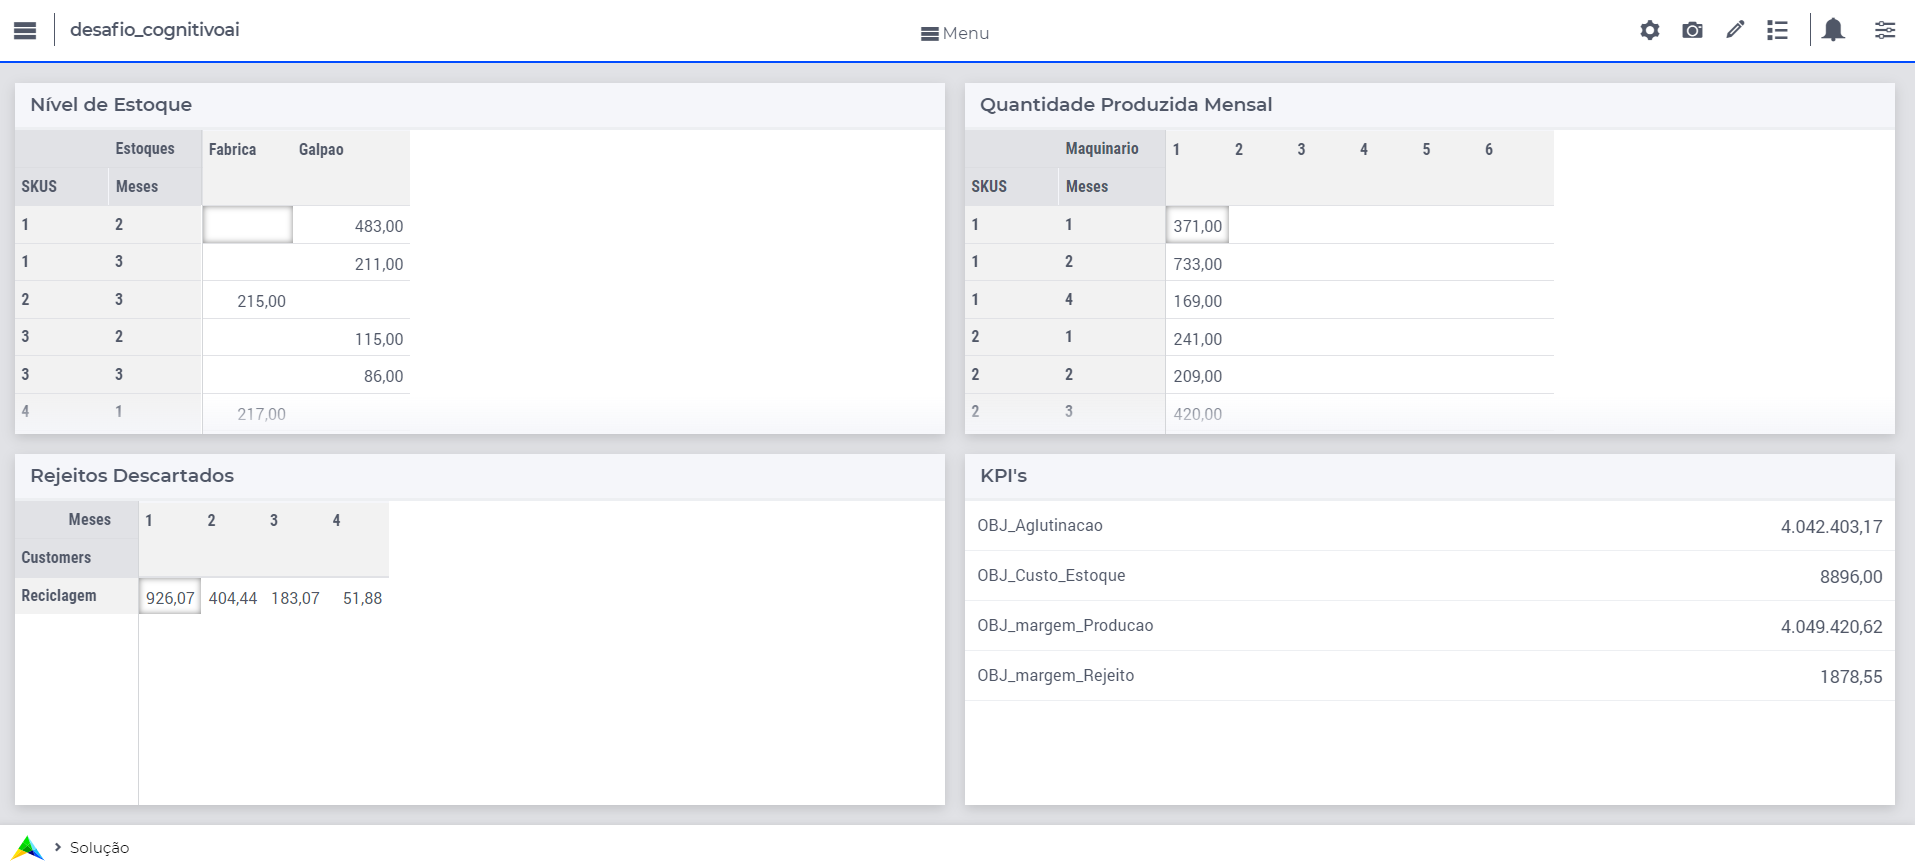

A partir da análise dos dados, notou-se que a empresa tem um lucro líquido de mais de 4 milhões de reais no período. Houve algumas máquinas que não foram alocadas na produção, mantendo portanto recursos em folga durante o período de produção, indicando talvez uma possível sobrecarga dos recursos restantes. 

O modelo decidiu preferencialmente vender para os clientes da reciclagem, que possuem alta demanda e podem pagar um valor mais considerável financeiramente pelos rejeitos. 

O custo de estoque correspondeu a uma porcentagem irrisória em relação ao lucro líquido, mostrando o potencial do planejamento analítico de demanda aplicado a estoques. 

# 5

O programa apresentou baixo Gap e poucas interações na busca da árvore no Algoritmo Branch and Bound, pois devido aos cortes de domínios realizados, o número de iterações necessárias tornou-se pequeno, executando em aproxidamente 5 segundos. 